In [1]:
from scipy.stats import gamma,lognorm
import numpy as np
from scipy import integrate 
import pandas as pd
import matplotlib.pyplot as plt
import random

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'

def read_data(url, country):

    countries= pd.read_csv(url)

    countries = countries[countries['Country/Region']==country]
    date = list(countries.columns[4:len(countries.columns)])
    cases = [sum(countries[d]) for d in date]
    f = open("tmp.csv","w")

    print("date,deaths,state",file=f)

    for i in range(len(date)):
        print(date[i],",",cases[i],",",country,file=f)

    f.close()
        
    countries = pd.read_csv("tmp.csv",index_col=['date'],parse_dates=['date'],squeeze=True).sort_index()
    return countries

# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2819789/#!po=57.6923

countries = ["US","United Kingdom","France","Swiss","Belgium","Turkey","Germany","Netherlands","Denmark","Portugal","Australia","Argentina","Brazil","New Zealand","Peru","Bolivia","South Africa","Chile","Uruguay","Equador"]

week_sim = ['2020-03-17','2020-03-18','2020-03-19','2020-03-20','2020-03-21','2020-03-22','2020-03-23','2020-03-24']

results = np.zeros((len(countries),500))


for c in range(len(countries)):
    deathsdf = read_data(url,countries[c])
    d = [deathsdf.loc[w]['deaths'] if deathsdf.loc[w]['deaths'] else 1 for w in week_sim]
    for i in range(500):
        gt = gamma(a=3.9)
        deaths = random.choice(d)/random.uniform(0.005,0.01)
        r = np.log(deaths)/30

        f = lambda x: gt.pdf(x)*np.exp(-r*x)
        R0 = 1/integrate.quad(f, 0, np.inf)[0]
        results[c,i] = R0

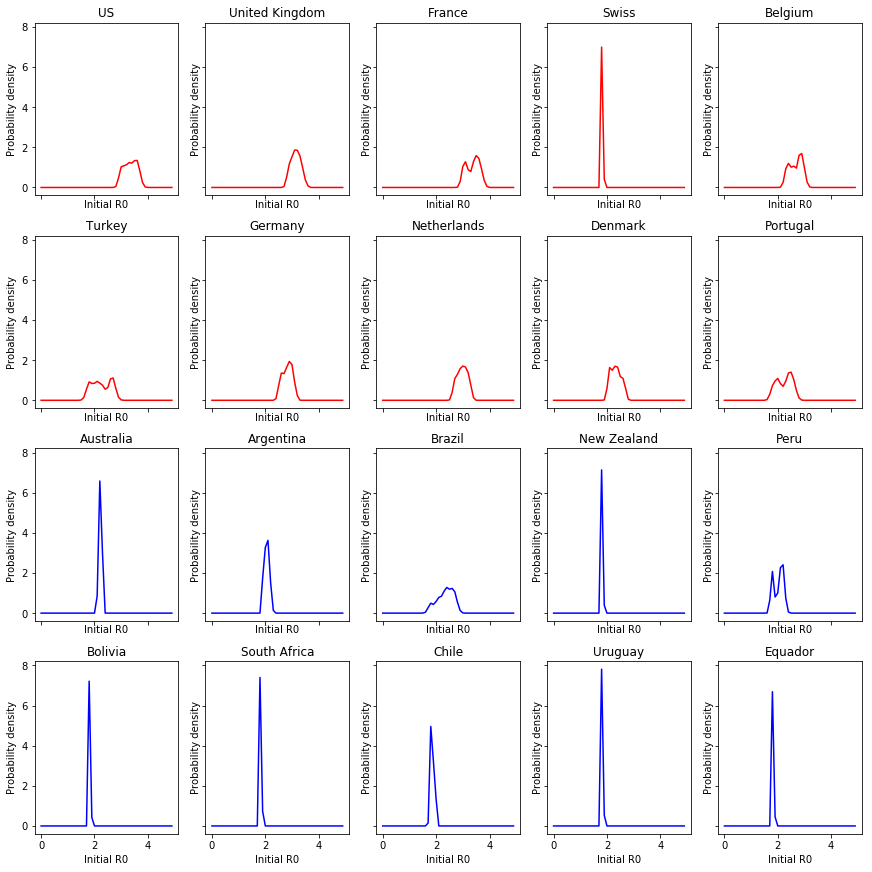

In [2]:
#plotting
from scipy.stats import gaussian_kde

fig, axs = plt.subplots(4, 5, figsize = (12,12), sharex=True, sharey=True,constrained_layout=True)

x = np.arange(0., 5, .1)

for i in range(len(countries)):
    if i > 9:
        clr = 'blue'
    else:
        clr = 'red'
    density = gaussian_kde(results[i,:])
    axs[int(int(i)/int(5)),i % 5].plot(x,density(x), color=clr)
    axs[int(int(i)/int(5)),i % 5].set_title(countries[i])
    axs[int(int(i)/int(5)),i % 5].set_xlabel("Initial R0")
    axs[int(int(i)/int(5)),i % 5].set_ylabel("Probability density")

In [3]:
df = pd.DataFrame(data=results, index=countries)

df.quantile([.05, .5, .95], axis = 1) 

,US,United Kingdom,France,Swiss,Belgium,Turkey,Germany,Netherlands,Denmark,Portugal,Australia,Argentina,Brazil,New Zealand,Peru,Bolivia,South Africa,Chile,Uruguay,Equador
0.05,2.964748,2.856173,2.995937,1.751532,2.303040,1.763044,2.524980,2.669420,2.054389,1.792147,2.127633,1.902782,1.792579,1.750853,1.757359,1.751694,1.751857,1.752246,1.751859,1.749154
0.50,3.341268,3.144065,3.420031,1.800332,2.735007,2.249444,2.842759,2.986295,2.327724,2.317293,2.211106,2.059126,2.385577,1.801750,2.093914,1.805155,1.804298,1.836819,1.797940,1.799411
0.95,3.684612,3.428888,3.721197,1.874319,2.993253,2.728931,3.105574,3.274270,2.661815,2.634494,2.312870,2.212139,2.742349,1.872015,2.254339,1.873176,1.878712,1.994754,1.876063,1.873439


In [4]:
from scipy.stats import ttest_ind

north_medianR0 = [df.quantile([0.5], axis=1)[c][0.5] for c in list(df.quantile([0.5], axis = 1))[0:10]]
south_medianR0 = [df.quantile([0.5], axis=1)[c][0.5] for c in list(df.quantile([0.5], axis = 1))[10:20]]

print("Average median R0 (north): ",round(np.mean(north_medianR0),1))
print("Average median R0 (south): ",round(np.mean(south_medianR0),1))
ttest_ind(north_medianR0,south_medianR0)

Average median R0 (north):  2.7
Average median R0 (south):  2.0


Ttest_indResult(statistic=4.1895721141615, pvalue=0.0005508331042648353)